# Velocities and animations

How fast is that plate going? Let's find out!

In [1]:
import pygplates
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry.polygon import LinearRing
import os

Import some plate rotation files. This time we'll also import topologies

In [2]:
rotation_filename = 'Data/Muller2019-Young2019-Cao2020_CombinedRotations.rot'
rotation_model = pygplates.RotationModel(rotation_filename)
    
coastlines_filename = 'Data/Global_EarthByte_GPlates_PresentDay_Coastlines.gpmlz'
coastlines = pygplates.FeatureCollection(coastlines_filename)

# import topologies. We need all 3 files
topology_filenames = ['Data/Muller2019-Young2019-Cao2020_PlateBoundaries.gpmlz',
                      'Data/Muller2019-Young2019-Cao2020_InactiveDeformation.gpmlz',
                      'Data/Muller2019-Young2019-Cao2020_ActiveDeformation.gpmlz']

topology_features = pygplates.FeatureCollection()
for file in topology_filenames:
    topology_feature = pygplates.FeatureCollection(file)
    topology_features.add(topology_feature)

## Creating Velocity Domain Points

The following cell contains a function that creates a GPlates gpml multipoint feature that contains points with the type 'Meshnode'. This is the same feature type created by the GPlates GUI dialog to create velocity domain points. 

For this function, the Lon/Lat locations of each point are taken as input arrays to the function - they could be any set of points that you can define, for even just one point. This feature can be written to a file (then used in the GPlates GUI).

Here, the function returns the meshnode feature for use in the later parts of the notebook

In [3]:
def make_GPML_velocity_feature(Lon, Lat):
    # function to make a velocity mesh nodes at an arbitrary set of points defined in Lat
    # Lon and Lat are assumed to be 1d arrays. 

    # Add points to a multipoint geometry
    multi_point = pygplates.MultiPointOnSphere([(float(lat), float(lon)) for lat, lon in zip(Lat, Lon)])

    # Create a feature containing the multipoint feature, and defined as MeshNode type
    meshnode_feature = pygplates.Feature(pygplates.FeatureType.create_from_qualified_string('gpml:MeshNode'))
    meshnode_feature.set_geometry(multi_point)
    meshnode_feature.set_name('Velocity Mesh Nodes from pygplates')
    
    output_feature_collection = pygplates.FeatureCollection(meshnode_feature)
    
    # NB: at this point, the feature could be written to a file using
    # output_feature_collection.write('myfilename.gpmlz')
    
    # for use within the notebook, the velocity domain feature is returned from the function
    return output_feature_collection

For the example below, we create a regular geographic grid of points at a spacing of 5 degree in longitude and latitude. We then call the function to create a gpml meshnode feature with points at these locations

In [4]:
# Generate points for regular long,lat grid
Xnodes = np.arange(-180, 180, 5)
Ynodes = np.arange(-90, 90, 5)
Xg, Yg = np.meshgrid(Xnodes, Ynodes)
Xg = Xg.flatten()
Yg = Yg.flatten()

velocity_domain_features = make_GPML_velocity_feature(Xg, Yg)
velocity_domain_features

## Calculating velocities at the domain points

Now that we have the points we want to calculate velocities at, let's start actually calculating them!

Here, we will calculate velocity values at each domain point, using resolved topological polygons to determine which plate each domain point is found within, and a rotation file to determine the motion of each plate.

The steps involved are:
- create a [`pygplates.PlatePartitioner`](https://www.gplates.org/docs/pygplates/generated/pygplates.platepartitioner) object based on the resolved topological polygons
- iterate through each point in each feature of the domain points feature collection, where for each point we:
    - find the plate id of the containing plate polygon (using [`pygplates.partition_point`](https://www.gplates.org/docs/pygplates/generated/pygplates.platepartitioner#pygplates.PlatePartitioner.partition_point))
    - find the stage rotation that describes the motion of this plate, using [`get_rotation`](https://www.gplates.org/docs/pygplates/generated/pygplates.rotationmodel#pygplates.RotationModel.get_rotation), the reconstruction time and a 'delta time' (e.g. this will get the velocity over the stage between 1 Ma and 0 Ma)
    - use [`pygplates.calculate_velocities`](https://www.gplates.org/docs/pygplates/generated/pygplates.calculate_velocities.html) to find the velocity at the point using this stage rotation
    - convert the velocity vector to representation including magnitude and azimuth using [`LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination`](https://www.gplates.org/docs/pygplates/generated/pygplates.localcartesian#pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination)

In [5]:
# Set the reconstruction time we want to compute the velocities
time = 0.

# Calculate velocities using a delta time interval of 1 My.
delta_time = 1.

# All domain points and associated (magnitude, azimuth, inclination) velocities for the current time.
all_domain_points = []
all_velocities = []

# Partition our velocity domain features into our topological plate polygons at the current 'time'.
plate_partitioner = pygplates.PlatePartitioner(topology_features, rotation_model, time)

# loop through...
for velocity_domain_feature in velocity_domain_features:

    # A velocity domain feature usually has a single geometry but we'll assume it can be any number.
    # Iterate over them all.
    for velocity_domain_geometry in velocity_domain_feature.get_geometries():
        for velocity_domain_point in velocity_domain_geometry.get_points():
            
            # save the velocity domain point in question
            all_domain_points.append(velocity_domain_point)
            
            # get the plate
            partitioning_plate = plate_partitioner.partition_point(velocity_domain_point)

            if partitioning_plate:
                # We need the newly assigned plate ID to get the equivalent stage rotation of that tectonic plate.
                partitioning_plate_id = partitioning_plate.get_feature().get_reconstruction_plate_id()

                # Get the stage rotation of partitioning plate from 'time + delta_time' to 'time'.
                equivalent_stage_rotation = rotation_model.get_rotation(time,
                                                                        partitioning_plate_id,
                                                                        time + delta_time)

                # Calculate velocity at the velocity domain point.
                # This is from 'time + delta_time' to 'time' on the partitioning plate.
                velocity_vectors = pygplates.calculate_velocities([velocity_domain_point], 
                                                                  equivalent_stage_rotation,
                                                                  delta_time)

                # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                velocities = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
                    [velocity_domain_point], velocity_vectors)
                all_velocities.append(velocities[0])

            else:
                all_velocities.append((0, 0, 0))

The result of this process is a list of velocity (magnitude, azimuth, inclination) tuples, since we converted using [`LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination`](https://www.gplates.org/docs/pygplates/generated/pygplates.localcartesian#pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination). Note that the inclination is always zero (or in some cases, a very small number close to zero).

For plotting, we put these values into separate lists, and also put the Lon and Lat coordinates into new lists as well (this is not strictly necessary here, but would be needed if we'd loaded the domain points from a file).


In [6]:
# new lists with velocity magnitude and azimuth
pt_vel_mag = []
pt_vel_az = []

# iterate through
for velocity_vector in all_velocities:
    pt_vel_mag.append(velocity_vector[0])
    pt_vel_az.append(velocity_vector[1])

# new lists with our coordinates
pt_lon = []
pt_lat = []
for pt in all_domain_points:
    pt_lon.append(pt.to_lat_lon()[1])
    pt_lat.append(pt.to_lat_lon()[0])

## Plotting velocity magnitude

The plot below is a simple scatter plot showing the velocity magnitude at each point mapped to colour. The velocity magnitudes generated on a regular grid could also be plotted using image/pcolor as a continuous grid. The plotted values show the significantly larger velocities in the Pacific domain compared to the Indian Ocean region.

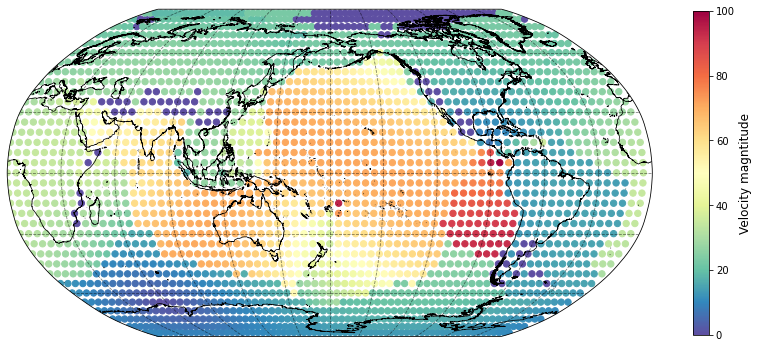

In [7]:
fig = plt.figure(figsize=(14, 10))

ax = fig.add_axes([0, 0, 0.8, 1.0], projection=ccrs.Robinson(central_longitude=180))
ax.coastlines(resolution='10m', color='black', linewidth=0.75)
ax.gridlines(color='black', linestyle='--', 
             xlocs=np.arange(-180, 180, 30),
             ylocs=np.arange(-90, 90, 30),
             alpha=0.5)
ax.set_global()

# Plot the lat-lon point pairs onto the map
im = ax.scatter(pt_lon, pt_lat, transform=ccrs.PlateCarree(), c=pt_vel_mag, s=40,
                cmap=plt.cm.Spectral_r, vmin=0, vmax=100)

# add colorbar
fig.colorbar(im, ax=ax, location='right', shrink=0.45).set_label('Velocity magntitude', fontsize=12)

plt.show()

## Calculating and plotting velocity vectors

To plot velocity vectors with `cartopy`, we need the north and east components of the velocity vector.

To do this, we will repeat the code above but convert the velocities using [`LocalCartesian.convert_from_geocentric_to_north_east_down`](https://www.gplates.org/docs/pygplates/generated/pygplates.localcartesian#pygplates.LocalCartesian.convert_from_geocentric_to_north_east_down) instead.

In [8]:
# Set the reconstruction time we want to compute the velocities
time = 0.

# Calculate velocities using a delta time interval of 1 My.
delta_time = 1.

# All domain points and associated (magnitude, azimuth, inclination) velocities for the current time.
all_domain_points = []
all_velocities = []

# Partition our velocity domain features into our topological plate polygons at the current 'time'.
plate_partitioner = pygplates.PlatePartitioner(topology_features, rotation_model, time)

# loop through...
for velocity_domain_feature in velocity_domain_features:

    # A velocity domain feature usually has a single geometry but we'll assume it can be any number.
    # Iterate over them all.
    for velocity_domain_geometry in velocity_domain_feature.get_geometries():
        for velocity_domain_point in velocity_domain_geometry.get_points():
            
            # save the velocity domain point in question
            all_domain_points.append(velocity_domain_point)
            
            # get the plate
            partitioning_plate = plate_partitioner.partition_point(velocity_domain_point)

            if partitioning_plate:
                # We need the newly assigned plate ID to get the equivalent stage rotation of that tectonic plate.
                partitioning_plate_id = partitioning_plate.get_feature().get_reconstruction_plate_id()

                # Get the stage rotation of partitioning plate from 'time + delta_time' to 'time'.
                equivalent_stage_rotation = rotation_model.get_rotation(time, 
                                                                        partitioning_plate_id,
                                                                        time + delta_time)

                # Calculate velocity at the velocity domain point.
                # This is from 'time + delta_time' to 'time' on the partitioning plate.
                velocity_vectors = pygplates.calculate_velocities([velocity_domain_point], 
                                                                  equivalent_stage_rotation,
                                                                  delta_time)

                # Convert global 3D velocity vectors to local (north, east, down) tuples (one tuple per point).
                velocities = pygplates.LocalCartesian.convert_from_geocentric_to_north_east_down(
                    [velocity_domain_point], velocity_vectors)
                
                # append velocities to list
                all_velocities.append(velocities[0])

            else:
                all_velocities.append((0, 0, 0))

Now we are almost ready to plot vectors in `cartopy`!

In [9]:
# prepare for plotting
pt_vel_n = []
pt_vel_e = []

for vel in all_velocities:
    pt_vel_e.append(vel.get_y())
    pt_vel_n.append(vel.get_x())

u = np.asarray(pt_vel_e).reshape((Ynodes.shape[0], Xnodes.shape[0]))
v = np.asarray(pt_vel_n).reshape((Ynodes.shape[0], Xnodes.shape[0]))

/Users/nickywright/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:529: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


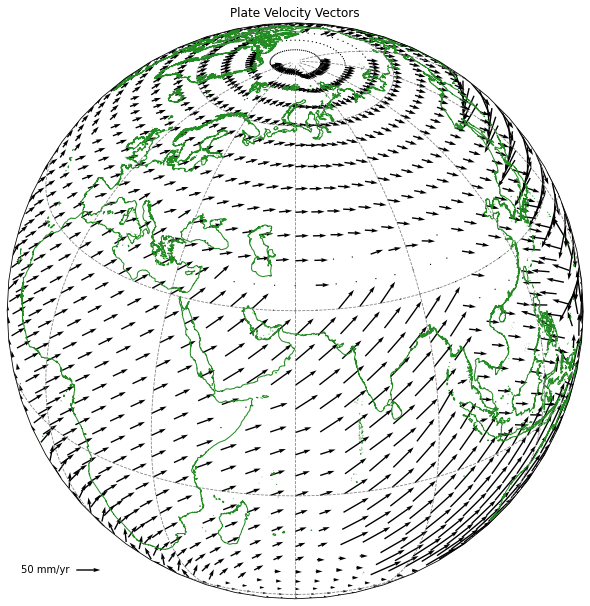

In [10]:
# create figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.Orthographic(central_longitude=60,
                                                                     central_latitude=30))

# draw coastlines and grids
ax.coastlines(resolution='10m', color='forestgreen', linewidth=1)
ax.gridlines(color='grey', linestyle='--', xlocs=np.arange(0, 360, 30), ylocs=np.arange(-90, 90, 40))

# Plot arrows using quiver. This time we use Xnodes and Ynodes, rather than pt_lon, pt_lat
Q = ax.quiver(Xnodes, Ynodes, u, v, scale=1200, transform=ccrs.PlateCarree(), color='k')
# make quiver key.
qk = plt.quiverkey(Q, 0.12, 0.05, 50, '50 mm/yr', labelpos='W')

# set plot title
ax.set_title('Plate Velocity Vectors')
plt.show()

## Velocity function

To make an animation of plate velocities through time, we can create a function with the above code, rather than typing out the code over and over again!

In [11]:
def get_plate_velocities(velocity_domain_features, topology_features, 
                         rotation_model, time, delta_time, rep='north_east'):
    """ Function to get velocites via pygplates. Returns the array of tuples "all_velocities",
    which by default will be north-east-down format"""
    
    # All domain points and associated (magnitude, azimuth, inclination) velocities for the current time.
    all_domain_points = []
    all_velocities = []

    # Partition our velocity domain features into our topological plate polygons at the current 'time'.
    plate_partitioner = pygplates.PlatePartitioner(topology_features, rotation_model, time)
    
    for velocity_domain_feature in velocity_domain_features:
        # A velocity domain feature usually has a single geometry but we'll assume it can be any number.
        # Iterate over them all.
        for velocity_domain_geometry in velocity_domain_feature.get_geometries():
            for velocity_domain_point in velocity_domain_geometry.get_points():
                
                all_domain_points.append(velocity_domain_point)
                
                partitioning_plate = plate_partitioner.partition_point(velocity_domain_point)
                
                if partitioning_plate:
                    # We need the newly assigned plate ID to get the equivalent stage rotation of that tectonic plate.
                    partitioning_plate_id = partitioning_plate.get_feature().get_reconstruction_plate_id()
                    
                    # Get the stage rotation of partitioning plate from 'time + delta_time' to 'time'.
                    equivalent_stage_rotation = rotation_model.get_rotation(time,
                                                                            partitioning_plate_id,
                                                                            time + delta_time)

                    # Calculate velocity at the velocity domain point.
                    # This is from 'time + delta_time' to 'time' on the partitioning plate.
                    velocity_vectors = pygplates.calculate_velocities(
                        [velocity_domain_point],
                        equivalent_stage_rotation,
                        delta_time)
                    
                    if rep == 'mag_azim':
                        # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                        velocities = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
                            [velocity_domain_point],
                            velocity_vectors)
                        all_velocities.append(velocities[0])

                    elif rep == 'north_east':
                        # Convert global 3D velocity vectors to local (north, east, down) tuples (one tuple per point).
                        velocities = pygplates.LocalCartesian.convert_from_geocentric_to_north_east_down(
                                [velocity_domain_point],
                                velocity_vectors)
                        all_velocities.append(velocities[0])
                else:
                    all_velocities.append((0, 0, 0))
                    
    return all_velocities

Now we can call the function, using the same features that we have already loaded/created, but for a different reconstruction time and/or delta time. 

This time we'll calculate velocities between 50 and 60 Ma, and then plot it similar to before.

In [12]:
# Set time parameters
reconstruction_time = 50.
delta_time = 10.

# Call the function we created above to get the velocities
all_velocities = get_plate_velocities(velocity_domain_features,
                                      topology_features,
                                      rotation_model,
                                      reconstruction_time,
                                      delta_time,
                                      rep='north_east')

reconstructed_coastlines = []
pygplates.reconstruct(coastlines, 
                      rotation_model,
                      reconstructed_coastlines,
                      reconstruction_time,
                      export_wrap_to_dateline=True) 

In [13]:
# prepare for plotting
pt_vel_n = []
pt_vel_e = []

for vel in all_velocities:
    if not hasattr(vel, 'get_y'): 
        pt_vel_e.append(vel[1])
        pt_vel_n.append(vel[0])
    else:
        pt_vel_e.append(vel.get_y())
        pt_vel_n.append(vel.get_x())

u = np.asarray(pt_vel_e).reshape((Ynodes.shape[0], Xnodes.shape[0]))
v = np.asarray(pt_vel_n).reshape((Ynodes.shape[0], Xnodes.shape[0]))

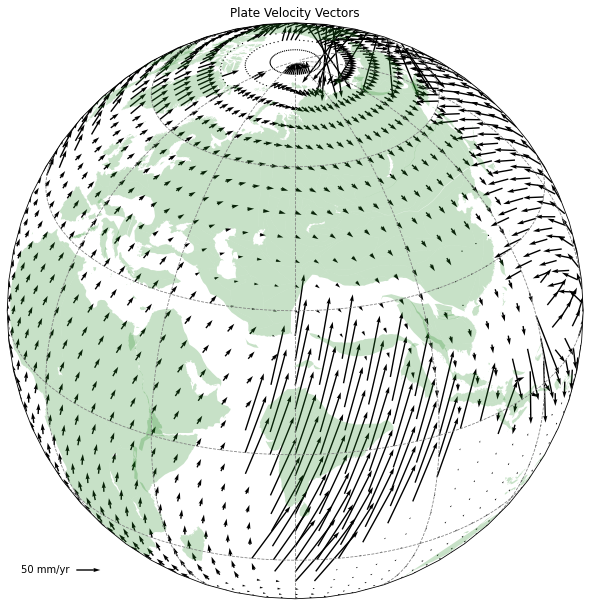

In [14]:
# create figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.Orthographic(central_longitude=60, central_latitude=30))

ax.gridlines(color='grey', linestyle='--', xlocs=np.arange(0, 360, 30), ylocs=np.arange(-90, 90, 30))

# plot reconstructed coastlines
coastlines_for_plotting = []
date_line_wrapper = pygplates.DateLineWrapper()
for polygon in reconstructed_coastlines:
    wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
    for poly in wrapped_polygons:
        coastlines_for_plotting.append(LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()]))
ax.add_geometries(coastlines_for_plotting, ccrs.PlateCarree(), facecolor='forestgreen', alpha=0.25) 


# Plot arrows using quiver. This time we use Xnodes and Ynodes, rather than pt_lon, pt_lat
Q = ax.quiver(Xnodes, Ynodes, u, v, scale=1200, transform=ccrs.PlateCarree(), color='k')
# make quiver key.
qk = plt.quiverkey(Q, 0.12, 0.05, 50, '50 mm/yr', labelpos='W')

# set plot title
ax.set_title('Plate Velocity Vectors')
plt.show()

### Add topologies

So far we haven't plotted our topologies, which means it is hard to see where our plates are. We can also plot them on our figure.

To do this, we first need to use [`pygplates.resolve_topologies`](https://www.gplates.org/docs/pygplates/generated/pygplates.resolve_topologies.html)

In [15]:
# Resolve our topological plate polygons (and deforming networks) to the current 'time'.
# We generate both the resolved topology boundaries and the boundary sections between them.
resolved_topologies = []
shared_boundary_sections = []
pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, reconstruction_time, shared_boundary_sections)

In [16]:
# create output directory for figures

figure_output_directory = 'velocity_figures'
if not os.path.exists(figure_output_directory):
    os.makedirs(figure_output_directory)

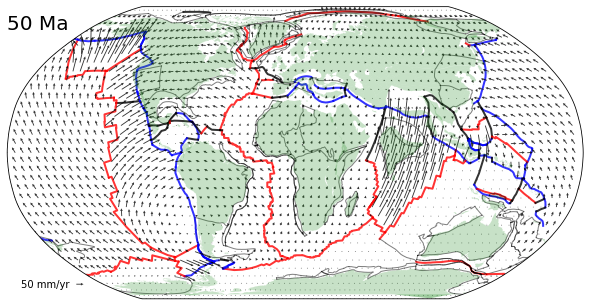

In [17]:
# create figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.Robinson(central_longitude=0))

# ax.gridlines(color='grey', linestyle=':', xlocs=np.arange(0, 360, 30), ylocs=np.arange(-90, 90, 30))

# ---- plot topologies
# create a dateline wrapper object
wrapper = pygplates.DateLineWrapper(0)
# Iterate over the shared boundary sections.
for shared_boundary_section in shared_boundary_sections:

    # Separate out the shared boundary sections, depending on what kind of gpml feature it is
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('MidOceanRidge'):
        # Ignore zero length segments - they don't have a direction.
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
            for geometry in split_geometry:
                X = []
                Y = []
                for point in geometry.get_points():
                    X.append(point.get_longitude()), Y.append(point.get_latitude())
                ax.plot(X, Y, 'r', linewidth=2, alpha=0.8, transform=ccrs.PlateCarree(), zorder=1, label='Mid ocean ridges')

    elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('SubductionZone'):
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
            for geometry in split_geometry:
                X = []
                Y = []
                for point in geometry.get_points():
                    X.append(point.get_longitude()), Y.append(point.get_latitude())
            ax.plot(X, Y, 'b', linewidth=2, alpha=0.8, transform=ccrs.PlateCarree(), zorder=1, label='Subduction zones')
    
    elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('Transform'):
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
            for geometry in split_geometry:
                X = []
                Y = []
                for point in geometry.get_points():
                    X.append(point.get_longitude()), Y.append(point.get_latitude())
            ax.plot(X, Y, 'k', linewidth=2, alpha=0.8, transform=ccrs.PlateCarree(), zorder=1, label='Transforms')

    elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('FractureZone'):
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
            for geometry in split_geometry:
                X = []
                Y = []
                for point in geometry.get_points():
                    X.append(point.get_longitude()), Y.append(point.get_latitude())
            ax.plot(X, Y, 'k', linewidth=2, alpha=0.8, transform=ccrs.PlateCarree(), zorder=1, label='FractureZone')
        
    else:
        # all other feature types
        # print(shared_boundary_section.get_feature().get_feature_type())
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
            for geometry in split_geometry:
                X = []
                Y = []
                for point in geometry.get_points():
                    X.append(point.get_longitude()), Y.append(point.get_latitude())
            ax.plot(X, Y, 'k', linewidth=1, alpha=0.5, transform=ccrs.PlateCarree(), zorder=1, label='Other plate boundaries')

# ---- plot coastlines
# plot reconstructed coastlines
coastlines_for_plotting = []
date_line_wrapper = pygplates.DateLineWrapper()
for polygon in reconstructed_coastlines:
    wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
    for poly in wrapped_polygons:
        coastlines_for_plotting.append(LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()]))
ax.add_geometries(coastlines_for_plotting, ccrs.PlateCarree(), facecolor='forestgreen', alpha=0.25) 


# Plot arrows using quiver. This time we use Xnodes and Ynodes, rather than pt_lon, pt_lat
Q = ax.quiver(Xnodes, Ynodes, u, v, scale=4000, transform=ccrs.PlateCarree(), color='k', alpha=0.8,
             headwidth=3, headlength=3, headaxislength=3, width=0.0015)
# make quiver key.
qk = plt.quiverkey(Q, 0.12, 0.05, 50, '50 mm/yr', labelpos='W')

# set plot title
ax.set_title('%.f Ma' % reconstruction_time, loc='left', y=0.9, fontsize=20)
plt.show()

## Velocity animations
Now we can combine all these parts into yet *another* function

In [18]:
def reconstruction_and_plot_velocities(reconstruction_time, delta_time):

    # ----- Reconstruct everything to 'reconstruction_time'
    
    # Call the function we created above to get the velocities
    all_velocities = get_plate_velocities(velocity_domain_features,
                                          topology_features,
                                          rotation_model,
                                          reconstruction_time,
                                          delta_time,
                                          rep='north_east')

    reconstructed_coastlines = []
    pygplates.reconstruct(coastlines, rotation_model, reconstructed_coastlines, reconstruction_time, export_wrap_to_dateline=True) 

    # Resolve our topological plate polygons (and deforming networks) to the current 'time'.
    # We generate both the resolved topology boundaries and the boundary sections between them.
    resolved_topologies = []
    shared_boundary_sections = []
    pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, reconstruction_time, shared_boundary_sections)
    
    # ----- prepare velocity files for plotting
    pt_vel_n = []
    pt_vel_e = []

    for vel in all_velocities:
        if not hasattr(vel, 'get_y'): 
            pt_vel_e.append(vel[1])
            pt_vel_n.append(vel[0])
        else:
            pt_vel_e.append(vel.get_y())
            pt_vel_n.append(vel.get_x())

    u = np.asarray(pt_vel_e).reshape((Ynodes.shape[0], Xnodes.shape[0]))
    v = np.asarray(pt_vel_n).reshape((Ynodes.shape[0], Xnodes.shape[0]))

    # ----- create figure
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.Robinson(central_longitude=0))

    # ax.gridlines(color='grey', linestyle='--', xlocs=np.arange(0, 360, 30), ylocs=np.arange(-90, 90, 40))

    # ---- plot topologies
    # create a dateline wrapper object
    wrapper = pygplates.DateLineWrapper(0)
    # Iterate over the shared boundary sections.
    for shared_boundary_section in shared_boundary_sections:

        # The shared sub-segments contribute either to the ridges or to the subduction zones.
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('MidOceanRidge'):
            # Ignore zero length segments - they don't have a direction.
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
                for geometry in split_geometry:
                    X = []
                    Y = []
                    for point in geometry.get_points():
                        X.append(point.get_longitude()), Y.append(point.get_latitude())
                    ax.plot(X, Y, 'r', linewidth=1.2, alpha=0.8, transform=ccrs.PlateCarree(), zorder=1, label='Mid ocean ridges')

        elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('SubductionZone'):
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
                for geometry in split_geometry:
                    X = []
                    Y = []
                    for point in geometry.get_points():
                        X.append(point.get_longitude()), Y.append(point.get_latitude())
                ax.plot(X, Y, 'b', linewidth=1.2, alpha=0.8, transform=ccrs.PlateCarree(), zorder=1, label='Subduction zones')

        elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('Transform'):
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
                for geometry in split_geometry:
                    X = []
                    Y = []
                    for point in geometry.get_points():
                        X.append(point.get_longitude()), Y.append(point.get_latitude())
                ax.plot(X, Y, 'k', linewidth=1.2, alpha=0.8, transform=ccrs.PlateCarree(), zorder=1, label='Transforms')

        elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('FractureZone'):
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
                for geometry in split_geometry:
                    X = []
                    Y = []
                    for point in geometry.get_points():
                        X.append(point.get_longitude()), Y.append(point.get_latitude())
                ax.plot(X, Y, 'k', linewidth=1.2, alpha=0.8, transform=ccrs.PlateCarree(), zorder=1, label='FractureZone')

        else:
            # all other feature types
            # print(shared_boundary_section.get_feature().get_feature_type())
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
                for geometry in split_geometry:
                    X = []
                    Y = []
                    for point in geometry.get_points():
                        X.append(point.get_longitude()), Y.append(point.get_latitude())
                ax.plot(X, Y, 'k', linewidth=0.75, alpha=0.5, transform=ccrs.PlateCarree(), zorder=1, label='Other plate boundaries')

    # ---- plot coastlines
    # plot reconstructed coastlines
    coastlines_for_plotting = []
    date_line_wrapper = pygplates.DateLineWrapper()
    for polygon in reconstructed_coastlines:
        wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
        for poly in wrapped_polygons:
            coastlines_for_plotting.append(LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()]))
    ax.add_geometries(coastlines_for_plotting, ccrs.PlateCarree(), facecolor='forestgreen', alpha=0.25) 
    
    # ---- plot arrows
    # Plot arrows using quiver. This time we use Xnodes and Ynodes, rather than pt_lon, pt_lat
    Q = ax.quiver(Xnodes, Ynodes, u, v, scale=4000, transform=ccrs.PlateCarree(),
                  color='k', alpha=0.4, headwidth=3, headlength=3,
                  headaxislength=3, width=0.0015)
    # make quiver key.
    plt.quiverkey(Q, 0.12, 0.05, 50, '50 mm/yr', labelpos='W', fontproperties={'size': 8})

    # set plot title
    ax.set_title('%.f Ma' % reconstruction_time, loc='left', y=0.9, fontsize=14)
    # saving the figure with -%s makes it much easier to reverse for ffmpeg without renaming the whole file!
    plt.savefig('%s/velocities-%sMa.png' % (figure_output_directory, reconstruction_time), bbox_inches='tight', dpi=150)
    plt.close()
    
    print('... Saved figure for %s Ma' % reconstruction_time)
    # plt.show()

Test the function for a time in the past

In [19]:
reconstruction_and_plot_velocities(100, 1)

... Saved figure for 100 Ma


Now we're ready to make an animation. Essentially we will save figures at 1 Myr increments, and then 'join' them together as a little movie

In [20]:
max_time = 20
delta_time = 1

for time in range(max_time + delta_time):
    reconstruction_and_plot_velocities(time, delta_time)

... Saved figure for 0 Ma
... Saved figure for 1 Ma
... Saved figure for 2 Ma
... Saved figure for 3 Ma
... Saved figure for 4 Ma
... Saved figure for 5 Ma
... Saved figure for 6 Ma
... Saved figure for 7 Ma
... Saved figure for 8 Ma
... Saved figure for 9 Ma
... Saved figure for 10 Ma
... Saved figure for 11 Ma
... Saved figure for 12 Ma
... Saved figure for 13 Ma
... Saved figure for 14 Ma
... Saved figure for 15 Ma
... Saved figure for 16 Ma
... Saved figure for 17 Ma
... Saved figure for 18 Ma
... Saved figure for 19 Ma
... Saved figure for 20 Ma


Here we'll use ffmpeg to create a gif and/or mp4 movie. Alternatively, we could use moviepy

In [21]:
# import moviepy.editor as mpy

# frame_list = []

# for time in np.arange(max_time, 0. ,-delta_time):
#     frame_list.append('%s/velocities-%.fMa.png' % (figure_output_directory, time))
    
# clip = mpy.ImageSequenceClip(frame_list, fps=5)
# clip.write_gif('velocities.gif')

In [19]:
%%bash
# ^ some cell magic. This is a bash cell

# make a gif
ffmpeg -r 4 -start_number -20 -i velocity_figures/velocities%dMa.png -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p -y velocities.gif

# make mp4
ffmpeg -r 4 -start_number -20 -i velocity_figures/velocities%dMa.png -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p -y velocities.mp4

ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 13.0.0 (clang-1300.0.29.3)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-librsvg --enable-libtheora --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --enable-zlib --disable-libjack --disable-libopencore-amrnb --disable-libopencore-amrwb --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --enable-opencl --disable-outdev=xv --enable-audiotoolbox --enable-videotoolbox --enable-sdl2 --disable-securetransport --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --enable-libzimg --arch=arm64 --enable-libx265 --enable-gpl --enable-postproc --enable-libx264 -

Animations can be displayed in the notebook itself using IPython.display.

For gifs, we can use `Image`

The movie will show up in a few seconds. Please be patient...


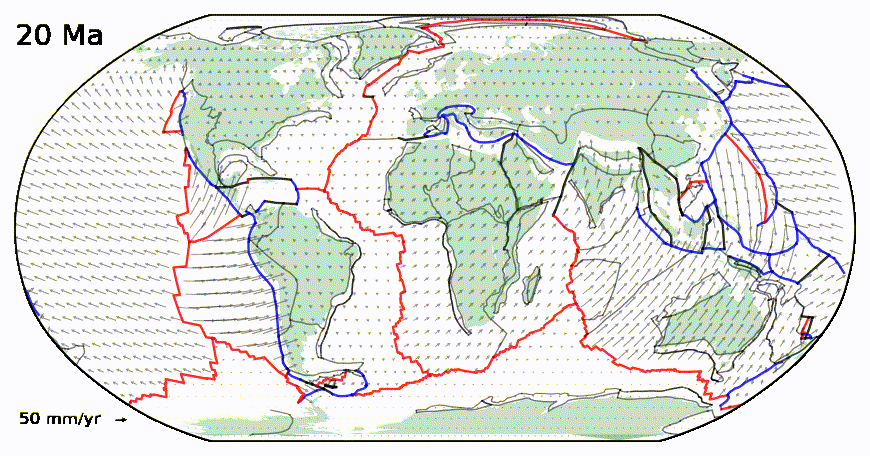

In [3]:
from IPython.display import Image
print('The movie will show up in a few seconds. Please be patient...')

Image('velocities.gif', format='png')

For mp4 files, we can display it in the notebook using `Video`

In [28]:
from IPython.display import Video
Video('velocities.mp4', embed=True, html_attributes="controls loop autoplay")